In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import utils
import forward_model
import globals
import least_squares
import section_search
import coordinate_descent
import initialization

import torch

/data/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/gco/__init__.py:7: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, name):


In [2]:
# globals.init_NYUv2()

# # EXPERIMENT_NAME = 'coord-descent-bracket-search'
# # experiment_folder = utils.create_experiment_folder(EXPERIMENT_NAME)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(device)

# IMAGE_RANGE = 255.

# # load data 
# # gt_aif, gt_dpt = utils.load_single_sample(sample='0101', set='train', fs=5, res='half')
# gt_aif, gt_dpt, _ = utils.load_sample_image(fs=5, res='half')
# gt_aif = gt_aif * IMAGE_RANGE

# plt.imshow(gt_aif / IMAGE_RANGE)
# plt.show()

# plt.imshow(gt_dpt)
# plt.colorbar()
# plt.show()

# width, height = gt_dpt.shape
# fs = len(globals.Df)
# print(fs)

# max_kernel_size = utils.kernel_size_heuristic(width, height)
# print('adaptive kernel size set to',max_kernel_size)
# utils.update_max_kernel_size(max_kernel_size)

Found at: /home/eecs/holly_jackson/dfd/MobileDepth/aligned-focus-stack/Aligned/Figure5/telephone
Focal depths: [55.991276 53.658607 61.714252 65.94624  62.69156  55.84957  42.03351
 39.67298  35.4783   34.204334 31.07799  28.866056 27.349936 25.552002
 23.60648  22.317997 21.234652 19.977226 18.672525 17.959293 16.996733
 16.334366 15.712561 14.910123 14.506627 14.002304 13.331587 12.840059
 12.435958 11.941948 11.42819  10.91933  10.      ]
Apertures: 26.501988
Focal length: 2.0
(33, 360, 640, 3)


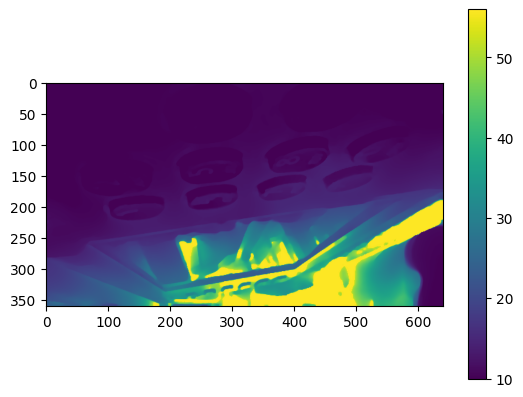

9.943523 55.991276
(33, 360, 640, 3) 11.0 255.0
Pixel size: 1
33 360 640
float32 float32
Depth range: 1 - 70
Dpt result range: 9.943523 - 55.991276


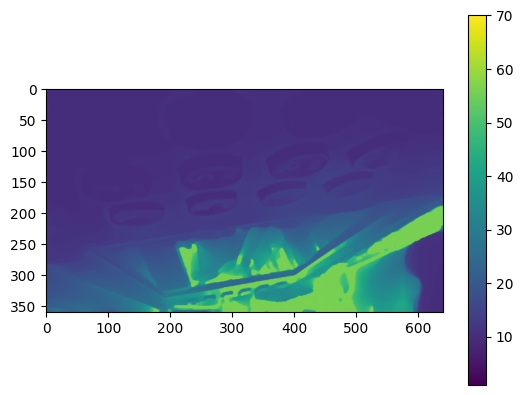

Mean: 18.83607
Median: 11.806222
Standard Deviation: 13.385375


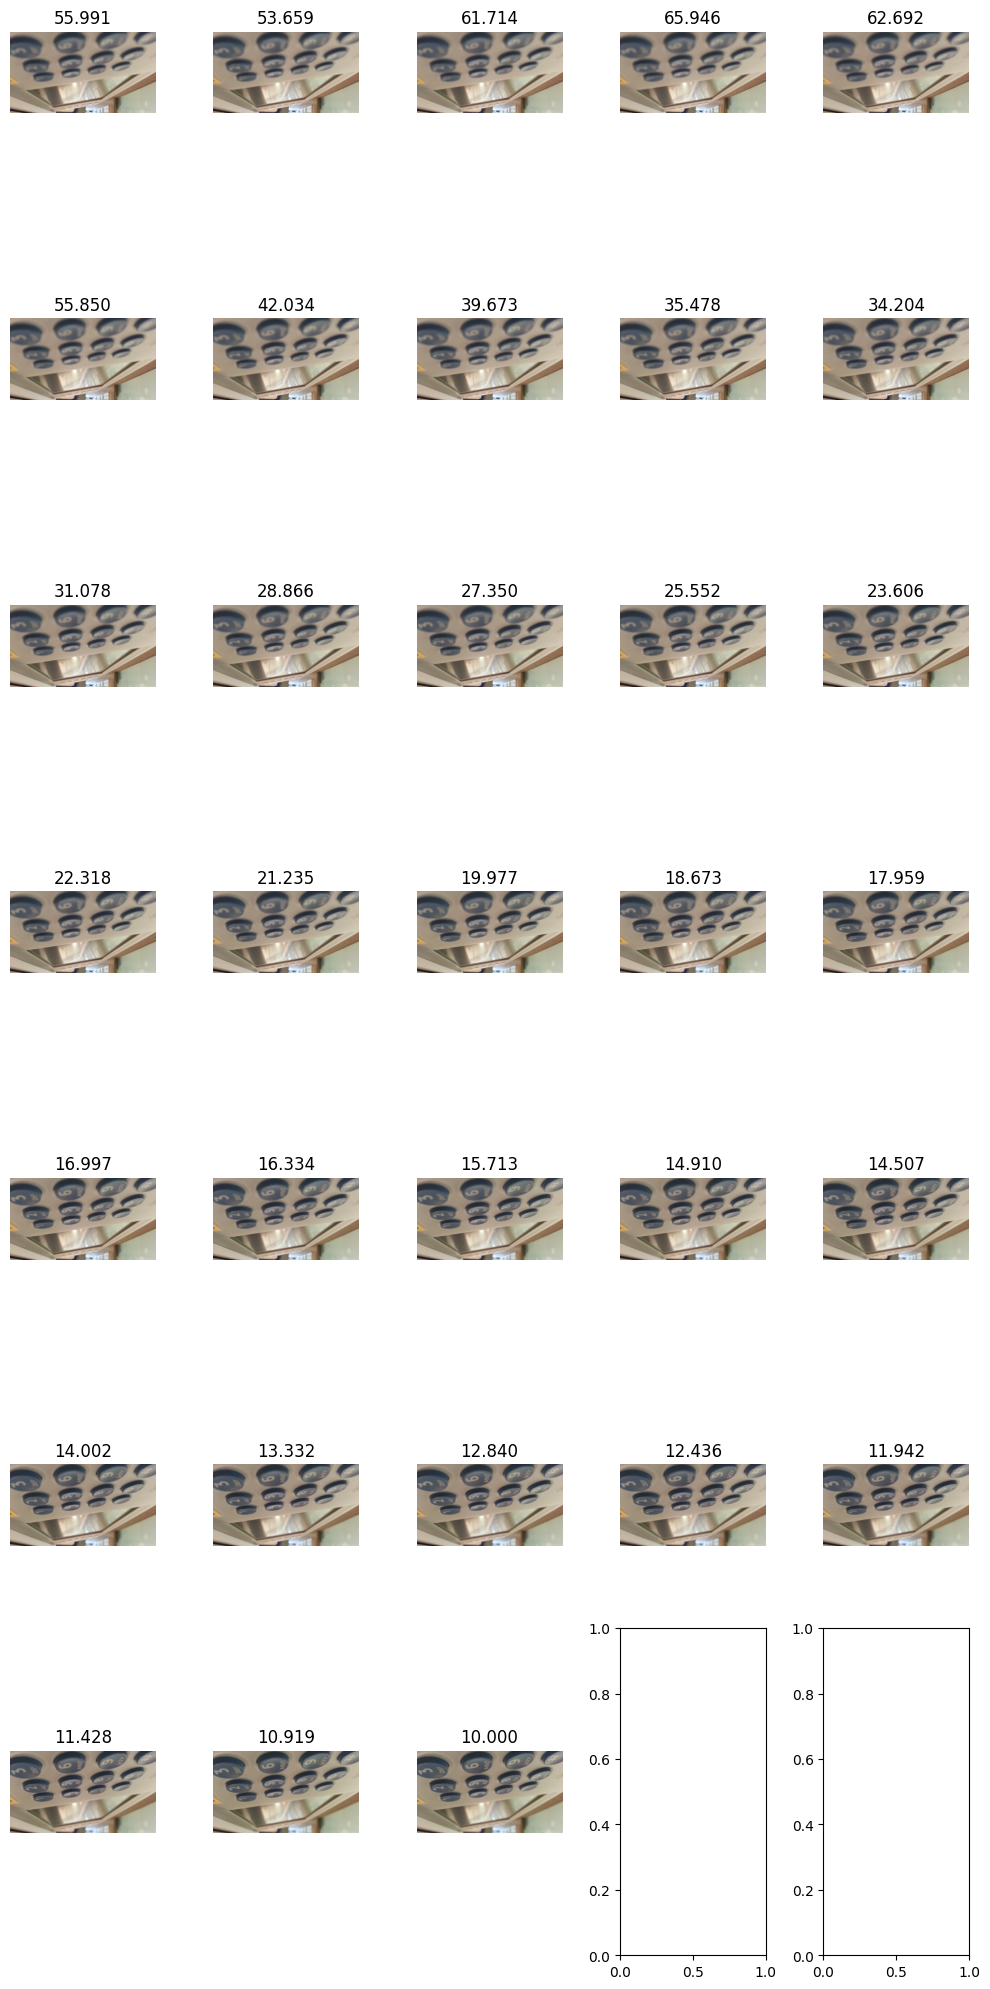

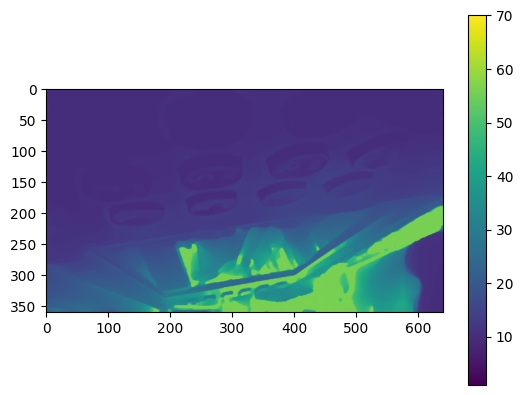

adaptive kernel size set to 21


In [3]:
globals.init_MobileDepth()

IMAGE_RANGE = 255.
example_name = "telephone"
# ["keyboard", "bottles", "fruits", "metals", "plants", "telephone", "window", "largemotion", "smallmotion", "zeromotion", "balls"]:

defocus_stack, gt_dpt, scale_mat = utils.load_single_sample_MobileDepth(example_name)

# defocus_stack = np.stack([
#     skimage.transform.resize(img, (img.shape[0] // 2, img.shape[1] // 2), anti_aliasing=True)
#     for img in defocus_stack
# ], axis=0)
# globals.ps = 2

defocus_stack *= IMAGE_RANGE 

print(defocus_stack.shape, defocus_stack.min(), defocus_stack.max())
print('Pixel size:', globals.ps)


fs, width, height, _ = defocus_stack.shape
print(fs, width, height)
print(gt_dpt.dtype, defocus_stack.dtype)

globals.min_Z = 1#max(0.1, globals.Df.min() - 3)
globals.max_Z = 70#min(max(width, height)*5, globals.Df.max() + 3)
print('Depth range:', globals.min_Z,'-', globals.max_Z)
print('Dpt result range:', gt_dpt.min(), '-',gt_dpt.max())

plt.imshow(gt_dpt, vmin=globals.min_Z, vmax=globals.max_Z)
plt.colorbar()
plt.show()

mean = np.mean(gt_dpt)
median = np.median(gt_dpt)
std = np.std(gt_dpt)

print("Mean:", mean)
print("Median:", median)
print("Standard Deviation:", std)

utils.plot_single_stack(defocus_stack / IMAGE_RANGE, globals.Df)

# plt.imshow(scale_mat)
# plt.colorbar()
# plt.show()

plt.imshow(gt_dpt, vmin=globals.min_Z, vmax=globals.max_Z)
plt.colorbar()
plt.show()

# print(scale_mat.shape)
# print(scale_mat)

max_kernel_size = utils.kernel_size_heuristic(width, height)
print('adaptive kernel size set to',max_kernel_size)
utils.update_max_kernel_size(11)




In [4]:
import time
globals.thresh = 0.5

width, height = gt_dpt.shape
gt_dpt_np = gt_dpt


t0 = time.time()
u_np, v_np, row_np, col_np, mask_np = forward_model.precompute_indices(width, height)
t1 = time.time()
print('precompute indices', t1-t0)

print(u_np.dtype, v_np.dtype, row_np.dtype, col_np.dtype, mask_np.dtype)
print(u_np.shape, v_np.shape)

sample_data = np.random.rand(row_np.size).astype(np.float32)
template_A_stack = forward_model.build_fixed_pattern_csr(width, height, fs, row_np, col_np, sample_data)


# t0 = time.time()
# u_np, v_np, row_np, col_np, mask_np = forward_model.precompute_indices_np(width, height)
# t1 = time.time()
# print('precompute indices np', t1-t0)


# t0 = time.time()
# r = forward_model.computer(gt_dpt, globals.Df, use_torch=True)
# t1 = time.time()
# r = r.unsqueeze(-1).unsqueeze(-1)
# print('computer torch', t1-t0)


t0 = time.time()
r_np = forward_model.computer(gt_dpt_np, globals.Df)#, use_torch=False)
t1 = time.time()
r_np = r_np[..., None, None]
print('computer', t1-t0)

print(r_np.shape, r_np.dtype)

# t0 = time.time()
# forward_model.computeG(r, u, v, kernel="gaussian", use_torch=True)
# t1 = time.time()
# print('computeG torch', t1-t0)


t0 = time.time()
G1, _ = forward_model.computeG_old(r_np, u_np, v_np)#, kernel="gaussian", use_torch=False)
t1 = time.time()
print('computeG', t1-t0)

t0 = time.time()
G2, _ = forward_model.computeG(r_np, u_np, v_np)#, kernel="gaussian", use_torch=False)
t1 = time.time()
print('computeG_separable', t1-t0)


abs_err = np.max(np.abs(G1 - G2))
rel_err = np.max(np.abs(G1 - G2) / (np.abs(G1) + 1e-20))
print("max abs err:", abs_err, "max rel err:", rel_err)

print("allclose?", np.allclose(G1, G2, rtol=1e-5, atol=1e-7))
# assert np.array_equal(G1, G2)


# t4 = time.time()
# A_stack = forward_model.buildA(gt_dpt, u, v, row, col, mask, use_torch=True, kernel="gaussian", op=None)
# t5 = time.time()
# print('buildA torch', t5-t4)


t2 = time.time()
A_stack = forward_model.buildA(gt_dpt_np, u_np, v_np, row_np, col_np, mask_np,
                               template_A_stack=template_A_stack)
t3 = time.time()
print('buildA', t3-t2)

# t6 = time.time()
# forward_model.forward_torch(gt_dpt, gt_aif, indices=(u, v, row, col, mask), kernel='gaussian', op=None)
# t7 = time.time()
# print('forward torch', t7-t6)

aif_init = initialization.compute_aif_initialization(defocus_stack, lmbda=0.05,
                                                     sharpness_measure='sobel_grad')

t8 = time.time()
forward_model.forward(gt_dpt_np, aif_init, indices=(u_np, v_np, row_np, col_np, mask_np), 
                      template_A_stack=template_A_stack)
t9 = time.time()
print('forward', t9-t8)

# todo -- why is buildA no torch still taking forever when im just stacking vectors
# todo fix forward torch_sparse.spmm


precomputing indices
precompute indices 3.521613597869873
float32 float32 int64 int32 bool
(1, 1, 1, 11, 11) (1, 1, 1, 11, 11)
computer 0.22998380661010742
(360, 640, 33, 1, 1) float32
computeG 10.081541299819946
computeG_separable 8.84035348892212
max abs err: 1.1920929e-07 max rel err: 5.062004e-06
allclose? True
buildA 22.827815294265747
forward 29.321043729782104


In [ ]:
# # test -- can the PGD reconstruct the ground truth AIF from the ground truth depth map?

# recon_aif = least_squares.bounded_fista(gt_dpt, defocus_stack, IMAGE_RANGE, maxiter=2000, gt=gt_aif)


# utils.plot_compare_rgb(gt_aif, recon_aif)
# plt.show()

# print(torch.mean((gt_aif - recon_aif)**2).item())

In [ ]:
dpt = torch.ones((width, height)) * 0.3
Df_expanded = globals.Df.view(1, 1, -1).to(dpt.device)
CoC = ((globals.D) 
        * (torch.abs(dpt.unsqueeze(-1) - Df_expanded) / (dpt.unsqueeze(-1)+1e-8)) 
        * (globals.f / (Df_expanded - globals.f)))
    
r = CoC / 2. / globals.ps
print(r.min())

In [ ]:
# recon_aif = least_squares.least_squares(gt_dpt, defocus_stack, maxiter = 500)
# utils.plot_compare_rgb(gt_aif, recon_aif)
# plt.show()

# print(torch.mean((gt_aif - recon_aif)**2).item())

In [ ]:
# AIF initialization

# aif_init = initialization.trivial_aif_initialization(defocus_stack)
aif_init = initialization.compute_aif_initialization(defocus_stack, lmbda=0.05, sharpness_measure='sobel_grad')
plt.imshow(aif_init / IMAGE_RANGE)
plt.show()

plt.imshow(defocus_stack[1] / IMAGE_RANGE)
plt.show()

In [ ]:
# -------------------
# COORDINATE DESCENT
# -------------------

depth_init = 1#torch.median(gt_dpt.cpu()).item()
# print('initializing depth to',depth_init)

dpt, aif, _ = coordinate_descent.coordinate_descent(defocus_stack, show_plots=False,
                                                 save_plots=True, num_epochs=1,
                                                 least_squares_first=True, depth_init=depth_init,
                                                 # least_squares_first=False, aif_init=aif_init, 
                                                 aif_method='fista', finite_differences=False,
                                                    k=1,
                                                num_Z=100, ls_maxiter=200, ls_maxiter_multiplier=1.05,#1.075, 
                                                 use_CUDA=False, vmin = gt_dpt.min(), vmax = gt_dpt.max())


In [ ]:
print('RMS', utils.compute_RMS(dpt.numpy(), gt_dpt.numpy()))
print('Rel', utils.compute_Rel(dpt.numpy(), gt_dpt.numpy()))
print(utils.compute_accuracy_metrics(dpt.numpy(), gt_dpt.numpy()))

In [ ]:
plt.imshow(utils.load_NYUv2_dpt('experiments/coord-descent_2025-08-13_14-22-48/iteration0/dpt_0.tiff', resize_frac=0.5))
plt.show()

In [ ]:
dpt_no_outliers = section_search.remove_outliers(dpt.cpu().numpy(), aif, diff_thresh = 2, tv_thresh = 0.15, patch_type = 'tv')
plt.imshow(dpt_no_outliers, vmin=0.7, vmax=1.9)
plt.show()

aif_last = least_squares.least_squares(torch.from_numpy(dpt_no_outliers), defocus_stack, maxiter=2500)

criterion = torch.nn.MSELoss()
recon = forward_model.forward_torch(torch.from_numpy(dpt_no_outliers), torch.from_numpy(aif_last))
loss = criterion(recon, defocus_stack_torch)
print(loss.item())

In [ ]:
utils.plot_compare_rgb(aif_last, gt_aif)
plt.show()

In [ ]:
utils.plot_compare_greyscale(dpt_no_outliers, gt_dpt, vmin=0.7, vmax=1.9)
plt.show()

In [ ]:
print(loss.item())


In [ ]:
dpt_no_outliers = section_search.remove_outliers(depth_map_golden, aif_last, diff_thresh = 2, tv_thresh = 0.15, patch_type = 'tv')
plt.imshow(dpt_no_outliers, vmin=0.7, vmax=1.9)
plt.show()

In [ ]:
# worst_coords = utils.get_worst_diff_pixels(dpt.cpu(), gt_dpt,
#     num_worst_pixels = 20)

# _, Z, _, all_losses = section_search.grid_search(aif.cpu(), defocus_stack_torch.cpu())

indices = forward_model.precompute_indices(width, height)
defocus_stacks = torch.zeros((len(Z), 5, width, height, 3))
for k in range(len(Z)):
    defocus_stack_k = forward_model.forward_torch(torch.full((width,height), Z[k]).to(aif.device),
                                                  aif, indices=indices)

    defocus_stacks[k] = defocus_stack_k
# 
for i, j in worst_coords[:5]:
    section_search.plot_grid_search_on_pixel(i.item(), j.item(), Z, all_losses, gt_dpt)
    
    i_min = max(0, i.item()-max_kernel_size//2)
    i_max = min(width, i.item()+max_kernel_size//2+1)
    j_min = max(0, j.item()-max_kernel_size//2)
    j_max = min(height, j.item()+max_kernel_size//2+1)
    plt.imshow(aif.cpu()[i_min:i_max, j_min:j_max] / 255.)
    plt.title("Local AIF region for ("+str(i.item())+", "+str(j.item())+")")
    plt.show()
    print('Red range:',aif.cpu()[i_min:i_max, j_min:j_max, 0].min().item(),
          '-',aif.cpu()[i_min:i_max, j_min:j_max, 0].max().item())
    print('Green range:',aif.cpu()[i_min:i_max, j_min:j_max, 1].min().item(),
          '-',aif.cpu()[i_min:i_max, j_min:j_max, 1].max().item())
    print('Blue range:',aif.cpu()[i_min:i_max, j_min:j_max, 2].min().item(),
          '-',aif.cpu()[i_min:i_max, j_min:j_max, 2].max().item())
    print('TV of AIF region:',section_search.total_variation_torch(aif[i_min:i_max, j_min:j_max]).item())
    # plt.imshow(gt_aif.cpu()[i_min:i_max, j_min:j_max] / 255.)
    # plt.title("GT local region for ("+str(i.item())+", "+str(j.item())+")")
    # plt.show()
    
    plt.imshow(dpt.cpu()[i_min:i_max, j_min:j_max], vmin=0.9, vmax=1.7)
    plt.title("Local DPT region for ("+str(i.item())+", "+str(j.item())+")")
    plt.show()
    print('TV of depth map region:',section_search.total_variation_torch(dpt[i_min:i_max, j_min:j_max]).item())

    
    # plt.imshow(defocus_stacks[:,:,i.item(),j.item(),:] / 255.)
    # plt.show()

    
    mse = torch.mean((defocus_stacks[:,:,i.item(),j.item(),:] - defocus_stack_torch[:,i.item(),j.item(),:]) ** 2, axis=2)
    # plt.imshow(mse)
    # plt.colorbar()
    # plt.show()

    fig, ax = plt.subplots(figsize=(10, 20))
    cax = ax.imshow(mse, cmap="viridis", aspect="auto", interpolation="nearest")
    
    cbar = plt.colorbar(cax, ax=ax, shrink=0.3)
    cbar.set_label("Color Scale")
    
    ax.set_yticks(np.arange(len(Z)))
    ax.set_yticklabels([np.round(z,2) for z in Z], fontsize=8)
    ax.set_ylabel('Z (Depth)', fontsize=10)
    
    ax.set_xticks(np.arange(len(globals.Df)))
    ax.set_xticklabels([df.item() for df in globals.Df], fontsize=8)
    ax.set_xlabel('d_f (Focus Setting in Focal Stack)', fontsize=10)
    
    ax.grid(which="minor", color="white", linestyle="-", linewidth=1)
    ax.set_xticks(np.arange(-0.5, 5, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, 100, 1), minor=True)
    
    plt.show()



In [ ]:
plt.imshow((dpt.cpu()-gt_dpt.cpu())**2)
plt.colorbar()
plt.title('(DPT - GT DPT)^2')
plt.show()

In [ ]:
tol=0.1
for df in globals.Df:
    mask = np.abs(gt_dpt.detach().cpu().numpy() - df.item()) <= tol
    y_coords, x_coords = np.where(mask)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(gt_dpt.cpu(), vmin=0.9, vmax=1.7)
    plt.scatter(x_coords, y_coords, color='red', marker='x', s=10, label=f'Within ±{tol} of {df}m')
    plt.legend()
    plt.title('Points Close to '+str(df.item())+' m')
    plt.axis('off')
    plt.show()

In [ ]:
pad = max_kernel_size // 2
width, height, _ = aif.shape

gt_aif_tv_map = np.zeros((width, height))
aif_tv_map = np.zeros((width, height))
gt_tv_map = np.zeros((width, height))
tv_map = np.zeros((width, height))

for i in range(pad, width - pad):
    for j in range(pad, height - pad):
        gt_window = gt_aif.cpu()[i - pad:i + pad + 1, j - pad:j + pad + 1]
        gt_aif_tv_map[i, j] = coordinate_descent.total_variation_torch(gt_window).item()
        window = aif.cpu()[i - pad:i + pad + 1, j - pad:j + pad + 1]
        aif_tv_map[i, j] = coordinate_descent.total_variation_torch(window).item()
        
        gt_window = gt_dpt.cpu()[i - pad:i + pad + 1, j - pad:j + pad + 1]
        gt_tv_map[i, j] = coordinate_descent.total_variation_torch(gt_window).item()
        window = dpt.cpu()[i - pad:i + pad + 1, j - pad:j + pad + 1]
        tv_map[i, j] = coordinate_descent.total_variation_torch(window).item()

vmin = min(aif_tv_map.min(), gt_aif_tv_map.min())
vmax = max(aif_tv_map.max(), gt_aif_tv_map.max())
utils.plot_compare_greyscale((aif_tv_map - vmin) / (vmax-vmin), (gt_aif_tv_map - vmin) / (vmax-vmin))
# plt.title('TV of AIF')
plt.show()

vmin = min(tv_map.min(), gt_tv_map.min())
vmax = max(tv_map.max(), gt_tv_map.max())
utils.plot_compare_greyscale((tv_map - vmin) / (vmax-vmin), (gt_tv_map - vmin) / (vmax-vmin))
# plt.title('TV of depth maps')
plt.show()

In [ ]:
print(dpt.cpu()[i.item(),j.item()])
print(gt_dpt.cpu()[i.item(),j.item()])

In [ ]:
u, v, row, col, mask = indices

r = forward_model.computer(gt_dpt, globals.Df)
print(r.shape)
_, _, fs = r.shape
r = r.unsqueeze(-1).unsqueeze(-1)
    
G, _ = forward_model.computeG(r, u, v)
print(G.shape)

In [ ]:
print(r[i.item(),j.item()])

In [ ]:
num_plots = len(globals.Df)
fig, axes = plt.subplots(1, num_plots, figsize=(20, 5), constrained_layout=True)

vmin = 0#torch.min(G[222, 178, :, :, :]).item()
vmax = 0.05#torch.max(G[222, 178, :, :, :]).item()

# Plot each subplot with a shared color scale
for k in range(num_plots):
    im = axes[k].imshow(G[i.item(), j.item(), k, :, :].cpu(), vmin=vmin, vmax=vmax)  # Ensure it's on CPU for plotting
    axes[k].set_title(globals.Df[k].item())
    print(G[i.item(), j.item(), k, :, :].sum())

# Create a global colorbar
cbar = fig.colorbar(im, ax=axes, orientation="vertical", fraction=0.02, pad=0.02)
cbar.set_label("Color Scale")

# Show the figure
plt.title('Blur Kernels')
plt.show()

In [ ]:
utils.plot_single_stack(defocus_stack_torch[:,i_min:i_max,j_min:j_max,:], globals.Df, recon_max=255.)


In [ ]:
utils.plot_single_stack(forward_model.forward_torch(dpt.cpu(), aif.cpu())[:,i_min:i_max,j_min:j_max,:], globals.Df, recon_max=255.)


In [ ]:
print(u.shape, v.shape, r.shape, G.shape)

In [ ]:
print(defocus_stack_torch[i.item(),j.item()])

In [ ]:
forward_model.forward_torch(dpt.cpu(), aif.cpu())[:,i_min:i_max,j_min:j_max,:]